# step0: dependencies

In [1]:
import numpy as np
import os
from random import shuffle
import re
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import collections
import time

%matplotlib inline

In [2]:
import urllib.request
import zipfile
import lxml.etree

# step1: load data
output:  
**input_texts**: list of 2085 talk transcriptions (entire text, not tokenized, mixed case, punctuation etc.)  
**labels**: corresponding list of 2085 strings containing several keywords each  

In [3]:
# Download the dataset if it's not already there
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [4]:
# extract both the texts and the labels from the xml file
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_texts = doc.xpath('//content/text()')
labels = doc.xpath('//head/keywords/text()')
del doc
#print(input_texts[0])
#print(labels[0])

# step2: preprocessing inputs and labels and building embeddings
output:  
**inputs_train**: list of 1585 tuples of (token_list, label_integer) for training  
**inputs_test**: list of 250 tuples of (token_list, label_integer) for testing  
**inputs_cv**: list of 250 tuples of (token_list, label_integer) for cv

In [5]:
# preprocess the texts: lowercase, remove text in parentheses, remove punctuation, tokenize into words (split on whitespace)
#removing text in parentheses
input_texts = [re.sub(r'\([^)]*\)', '', input_text) for input_text in input_texts]
#lowercase
input_texts = [input_text.lower() for input_text in input_texts]
#remove punctuation
input_texts = [re.sub(r'[^a-z0-9]+', ' ', input_text) for input_text in input_texts]
input_texts = [re.sub(r'[0-9]+', 'number_token', input_text) for input_text in input_texts]
#tokenize into words
input_texts = [input_text.split() for input_text in input_texts]
len(input_texts)
#input_texts[0][:50]

2085

In [6]:
#get list of all words, and feed them into a Counter
all_words = [word for input_text in input_texts for word in input_text]
print("There are {} words in the dataset.".format(len(all_words)))
all_words_counter = collections.Counter(all_words)

#remove some noise, take away the 50 most common and all words that only appear once
#all_words_counter.most_common()[-100:-1] #100 least common
#all_words_counter.most_common(50) #50 most common
#[word for word_count_pair in all_words_counter.most_common() if word_count_pair[1] == 1] #all with a count of only one
only_once = [word_count_pair[0] for word_count_pair in all_words_counter.most_common() if word_count_pair[1] == 1]
print("There are {} words that appear only once.".format(len(only_once)))

to_remove = only_once
#TODO: this removes number_token also?
to_remove += [word_count_pair[0] for word_count_pair in all_words_counter.most_common(50)]

#############WARNING!##############
#this step took ~1h on my 2013 i5!
test = [[word for word in input_text if word not in to_remove] for input_text in input_texts]

new_all_words = [word for input_text in test for word in input_text]
print("There are now only {} words in the dataset.".format(len(new_all_words)))

#input_texts[0]

There are 4474850 words in the dataset.
There are 17997 words that appear only once.
There are now only 2363349 words in the dataset.


In [7]:
input_texts = test

In [8]:
#padding every text to the max text length for later batching
l_max = max([len(text) for text in input_texts])
for text in input_texts:
    text += ['<PAD>'] * (l_max - len(text))
#print(input_texts[0][-10:-1])
#print(np.mean([len(text) for text in input_texts]) == l_max)

In [9]:
# preprocess the labels: search for occurences of the keywords "technology", "entertainment" or "design" and build labels
label_lookup = ['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']
for i in range(len(labels)):
    ted_labels = ['o', 'o', 'o']
    keyword_list = labels[i].split(', ')
    if 'technology' in keyword_list:
        ted_labels[0] = 'T'
    if 'entertainment' in keyword_list:
        ted_labels[1] = 'E'
    if 'design' in keyword_list:
        ted_labels[2] = 'D'
    labels[i] = ''.join(ted_labels)
    labels[i] = label_lookup.index(labels[i])
len(labels)
labels[:20]

[0, 0, 0, 3, 5, 0, 0, 0, 0, 5, 0, 3, 2, 5, 0, 0, 3, 0, 5, 0]

In [10]:
# creating the unique vocabulary lookup
vocab_list = list(set([word for input_text in input_texts for word in input_text]))
word_to_index = {}
index_to_word = {}
for i, word in enumerate(vocab_list):
    word_to_index[word] = i
    index_to_word[i] = word
input_indices_list = []
for input_text in input_texts:
    input_indices_list.append([word_to_index[word] for word in input_text])
#del vocab_list
#del input_texts

In [11]:
#load glove word vectors
glove = KeyedVectors.load_word2vec_format('glove.6B.50d.w2vformat.txt', binary=False)

In [12]:
#creating embeddings, checking for each word in the input texts whether it is part of 
#the glove corpus, if yes intialize that row in the embeddings with the glove value, if
#not initialize it uniformly between [-1.0, 1.0]
voc_len = len(word_to_index)
print("vocabulary size: {} words".format(voc_len))
counter = 0
not_found_list = []
embeddings = np.random.uniform(-1.0, 1.0, size=(voc_len, 50))
for word, index in word_to_index.items():
    if word in glove.vocab:
        counter += 1
        embeddings[index] = glove[word]
    else:
        not_found_list.append(word)
print("found {} word vectors, {} of our vocabulary".format(counter, float(counter)/voc_len))
print("missing words e.g. {}".format(not_found_list[0:50]))
        

vocabulary size: 35665 words
found 34494 word vectors, 0.9671666900322445 of our vocabulary
missing words e.g. ['gorking', 'transgenesis', 'memorizer', 'acinus', 'randoms', 'hnumber_tokens', 'relaunchers', 'jacobaeus', 'gelem', 'reorientate', 'flyfire', 'genomically', 'monogamously', 'nehu', 'praxeology', 'ghemawat', 'otherizing', 'foldscope', 'corvisart', 'marseus', 'tilonia', 'cagoots', 'escalope', 'deoxyhemoglobin', 'pammy', 'number_tokenh', 'tedactive', 'sesfontein', 'mybo', 'soljacic', 'greenlab', 'tedyouth', 'bugness', 'supergays', 'paje', 'kamkwamba', 'retweeted', 'alaikum', 'deskbar', 'searchability', 'approtec', 'perony', 'pranitha', 'heforshe', 'pnumber_token', 'arghs', 'ockelford', 'dubowsky', 'shotglass', 'unignorable']


In [13]:
# combining the tokens and labels for each input, then shuffle them and split into train/test/cv
inputs_combined = list(zip(input_indices_list, labels))
shuffle(inputs_combined)
inputs_train = inputs_combined[:1585]
inputs_test = inputs_combined[1585:1835]
inputs_cv = inputs_combined[1835:]
print((len(inputs_train), len(inputs_test), len(inputs_cv)))
#print(inputs_train[0])
#print([index_to_word[i] for i in inputs_train[0][0]])
#print([input_pair[1] for input_pair in inputs_train])

(1585, 250, 250)


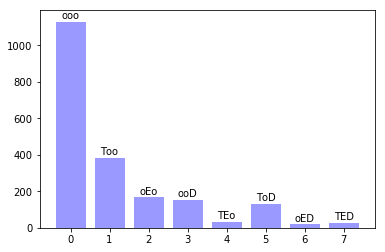

In [14]:
#plotting a histogram over the label distribution in the entire dataset
#as you can see 'ooo' is basically ~50% of the dataset, so an accuracy score
#of 50% could be reached by simply learning to predict 'ooo' all the time (not good)
Y_plot = np.histogram(labels, bins=8)[0]
X_plot = np.arange(8)
plt.bar(X_plot, +Y_plot, facecolor='#9999ff', edgecolor='white')
for x,y in zip(X_plot,Y_plot):
    plt.text(x, y+0.05, label_lookup[x], ha='center', va= 'bottom')

# step3: building the tensorflow model

In [15]:
# building the tensorflow logistic regression model
import tensorflow as tf


In [33]:
class TextClassifier(object):
    def __init__(self, lr, activation, train_algo, embeddings, train_embeddings, voc_len, embed_size, batch_size, hidden_units, classes):
        #placeholders
        #(batch_size left)
        self.input_ph = tf.placeholder(tf.int32, shape=(None, None), name='input')
        self.labels_ph = tf.placeholder(tf.int32, shape=(None, classes), name='labels')
        self.dropout_ph = tf.placeholder(tf.float32, shape=(), name='dropout')  
        
        #embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            #depending on whether a pre-trained embedding is provided and whether or not
            #the embedding should be trainable
            if embeddings is not None and train_embeddings is True:
                self.L = tf.Variable(embeddings, name="L")
            elif embeddings is not None and train_embeddings is False:
                self.L = tf.constant(embeddings, name="L")
            else:
                self.L = tf.Variable(tf.random_uniform([voc_len, embed_size], -1.0, 1.0), name="L")
            input_vectors = tf.nn.embedding_lookup(self.L, self.input_ph)
            X = tf.squeeze(tf.reduce_mean(input_vectors, axis=1, keep_dims=True), axis=1)
        
        #network model
        with tf.name_scope("network"):
            W1 = tf.Variable(tf.random_normal((embed_size, hidden_units), stddev=0.1), name="W1")
            b1 = tf.Variable(tf.zeros(hidden_units), name='b1')

            self.W2 = tf.Variable(tf.random_normal((hidden_units, classes), stddev=0.1), name="W2")
            b2 = tf.Variable(tf.zeros(classes), name='b2')
            
            if activation == 'relu':
                hidden = tf.nn.relu(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            elif activation == 'tanh':
                hidden = tf.nn.tanh(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            else:
                hidden = tf.nn.sigmoid(tf.matmul(tf.cast(X, tf.float32), W1) + b1)
            hidden = tf.nn.dropout(hidden, self.dropout_ph)

            output = tf.matmul(hidden, self.W2) + b2
            output = tf.nn.dropout(output, self.dropout_ph)
            #yhat = tf.nn.softmax(out) #no need to calc whole prob dist if we only want the argmax
            self.predictions = tf.argmax(output, axis=1)
        
        #loss
        with tf.name_scope("loss"):
            self.losses = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=self.labels_ph)
            l2_loss = tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(self.W2) + tf.nn.l2_loss(b2)
            self.loss = tf.reduce_mean(self.losses) + (0.01 * l2_loss)
            
        #acc
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.labels_ph, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            
        #training operation
        with tf.name_scope("training"):
            if train_algo == 'adam':
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
            elif train_algo == 'adagrad':
                self.train_op = tf.train.AdagradOptimizer(lr).minimize(self.loss)
            else:
                self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(self.loss)

In [34]:
class Trainer(object):
    def __init__(self, nn, train_data, cv_data, test_data, batch_size, train_dropout, epochs):
        self.nn = nn
        self.train_data = train_data
        self.cv_data = cv_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.train_dropout = train_dropout
        self.epochs = epochs
        self.W2, self.collect_preds, self.collect_truth = None, [], []

    def _get_data_batch(self, curr_index, batch_size, data):
        curr_batch = data[curr_index:curr_index+batch_size]
        input_batch_list, labels_batch_list = zip(*curr_batch) #unzip the list of input pair tuples (text, label)
        curr_input_batch = np.array(input_batch_list, dtype=np.int32)
        one_hot = np.zeros((len(labels_batch_list), classes))            
        one_hot[range(len(labels_batch_list)), labels_batch_list] = 1            
        curr_labels_batch = one_hot
        return curr_input_batch, curr_labels_batch
    
    def _print_status(self, epoch_loss, epoch_train_acc, epoch_cv_acc):
        print ("epoch train loss: {}, epoch train accuracy: {}, epoch cv accuracy: {} ".
               format(np.mean(epoch_loss), np.mean(epoch_train_acc), np.mean(epoch_cv_acc)))#, end="\r")
        
    def run_epoch(self, sess):
        self.W2 = None
        epoch_loss, epoch_train_acc, epoch_cv_acc = [], [], []
        #run training on the train data
        curr_index = 0
        while curr_index < len(self.train_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.train_data)
            feed_dict={self.nn.dropout_ph:self.train_dropout, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            self.W2, c_loss, c_losses, c_train_acc, _ = sess.run([self.nn.W2, self.nn.loss, self.nn.losses, self.nn.accuracy, self.nn.train_op], feed_dict=feed_dict)
            #print(c_losses)
            #print(c_loss)
            epoch_loss.append(c_loss)
            epoch_train_acc.append(c_train_acc)
            curr_index += self.batch_size
        
        #run cross evaluation on the cv data
        curr_index = 0
        while curr_index < len(self.cv_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.cv_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_cv_acc = sess.run(self.nn.accuracy, feed_dict=feed_dict)
            epoch_cv_acc.append(c_cv_acc)
            curr_index += self.batch_size
        
        self._print_status(epoch_loss, epoch_train_acc, epoch_cv_acc)
    
    def train(self):
        print("Starting training for {} epochs.".format(self.epochs))
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            for _ in range(self.epochs):
                self.run_epoch(sess)
            print("Done Training.")
            self._test(sess)
        
    def _test(self, sess):
        print("Testing the trained model on the test set.")
        #would be better to choose the best model on cv for this instead of simply the one from the last iteration
        curr_index = 0
        epoch_test_acc = []
        while curr_index < len(self.test_data):
            curr_input_batch, curr_labels_batch = self._get_data_batch(curr_index, self.batch_size, self.test_data)
            feed_dict={self.nn.dropout_ph:1.0, 
                       self.nn.input_ph:curr_input_batch, 
                       self.nn.labels_ph:curr_labels_batch}
            c_test_acc, test_predictions = sess.run([self.nn.accuracy, self.nn.predictions], feed_dict=feed_dict)
            epoch_test_acc.append(c_test_acc)
            self.collect_preds.extend(test_predictions)
            self.collect_truth.extend(np.argmax(curr_labels_batch, axis=1))
            curr_index += self.batch_size
        print("Test set accuracy: {}".format(np.mean(epoch_test_acc)))
        print("Done Testing.")      


# step4: model instantiation, training and testing

In [35]:
#config
embed_size = 50
batch_size = 50
hidden_units = 50
learning_rate = 0.03
voc_len = len(word_to_index)
classes = len(label_lookup)


#instantiate a network
#this can now be tested with all kinds of configurations
#'tanh', 'adam', dropout of 0.5 and a lr of 0.05 seems to work best for me
nn = TextClassifier(
    lr=learning_rate,
    activation='tanh',
    train_algo='adam',
    embeddings=embeddings, #or embeddings=None
    train_embeddings=True,
    voc_len=voc_len,
    embed_size=embed_size,
    batch_size=batch_size,
    hidden_units=hidden_units,
    classes=classes
)

#instantiate a trainer, train the model on the train data and then run the test on the test data
trainer = Trainer(
    nn=nn,
    train_data=inputs_train,
    cv_data=inputs_cv,
    test_data=inputs_test,
    batch_size=batch_size,
    train_dropout=0.5,
    epochs=50
)

trainer.train()

Starting training for 50 epochs.
epoch train loss: 2.049983501434326, epoch train accuracy: 0.40089285373687744, epoch cv accuracy: 0.5239999890327454 
epoch train loss: 1.6705362796783447, epoch train accuracy: 0.5112500190734863, epoch cv accuracy: 0.5399999618530273 
epoch train loss: 1.4753882884979248, epoch train accuracy: 0.5799107551574707, epoch cv accuracy: 0.5800000429153442 
epoch train loss: 1.3499927520751953, epoch train accuracy: 0.6247321367263794, epoch cv accuracy: 0.5760000348091125 
epoch train loss: 1.3982343673706055, epoch train accuracy: 0.6270535588264465, epoch cv accuracy: 0.6000000238418579 
epoch train loss: 1.2956435680389404, epoch train accuracy: 0.6383035778999329, epoch cv accuracy: 0.5680000185966492 
epoch train loss: 1.1923316717147827, epoch train accuracy: 0.7072321772575378, epoch cv accuracy: 0.5680000185966492 
epoch train loss: 1.0582771301269531, epoch train accuracy: 0.7407142519950867, epoch cv accuracy: 0.5920000076293945 
epoch train los

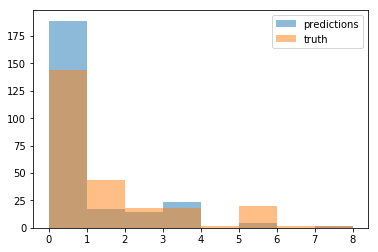

In [36]:
bins = np.arange(9)
plt.hist(np.array(trainer.collect_preds), bins, alpha=0.5, label='predictions')
plt.hist(np.array(trainer.collect_truth), bins, alpha=0.5, label='truth')
plt.legend(loc='upper right')  

In [37]:
np.histogram(trainer.collect_truth, bins=8)

(array([144,  44,  18,  18,   2,  20,   2,   2]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]))

# step5: visualizing the hidden to output weight matrix

In [38]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
plot_W2 = tsne.fit_transform(trainer.W2.T)

In [43]:
label_lookup

['ooo', 'Too', 'oEo', 'ooD', 'TEo', 'ToD', 'oED', 'TED']

In [44]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=plot_W2[:,0],
                                    x2=plot_W2[:,1],
                                    names=label_lookup))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)